In [2]:
%pip install tensorflow
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from tensorflow.keras.datasets import mnist
import os
import sys
import gzip
if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df1 = np.loadtxt('week8/data1.txt')
df2 = np.loadtxt('week8/data2.txt')

In [3]:
def quadratic_kernel(x1, x2):
    return (np.dot(x1, x2) + 1) ** 2

def rbf_kernel(x1, x2, gamma=0.1):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

In [12]:
class KernelPerceptron:
    def __init__(self, kernel=quadratic_kernel):
        self.kernel = kernel
        self.alpha = None
        self.b = 0
        self.labels = None
        self.X = None

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.alpha = np.zeros(n_samples)
        self.labels = y
        self.X = X
        misclassified = True

        while misclassified:
            misclassified = False
            for i in range(n_samples):
                pred_sum = 0
                for j in range(n_samples):
                    pred_sum += self.alpha[j] * y[j] * self.kernel(X[j], X[i]) 
                pred = np.sign(pred_sum + self.b)
                if pred != y[i]:
                    self.alpha[i] += 1
                    self.b += y[i]
                    misclassified = True

    def predict(self, X):
        predictions = []
        for x in X:
            pred_sum = 0
            for i in range(len(self.alpha)):
                pred_sum += self.alpha[i] * self.labels[i] * self.kernel(self.X[i], x)
            pred_sum += self.b
            pred = np.sign(pred_sum)
            predictions.append(pred)
        
        return np.array(predictions)

In [13]:
def plot_decision_boundary(X, y, model, title="Decision Boundary"):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.show()

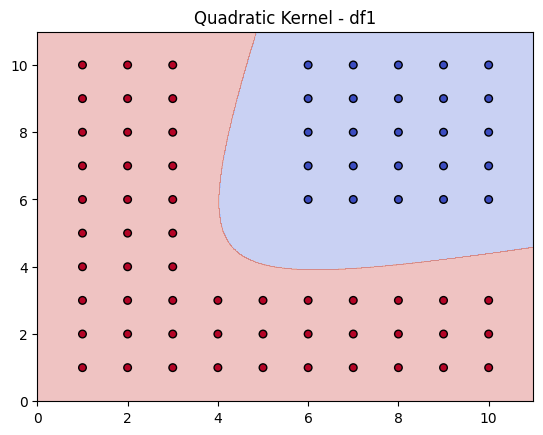

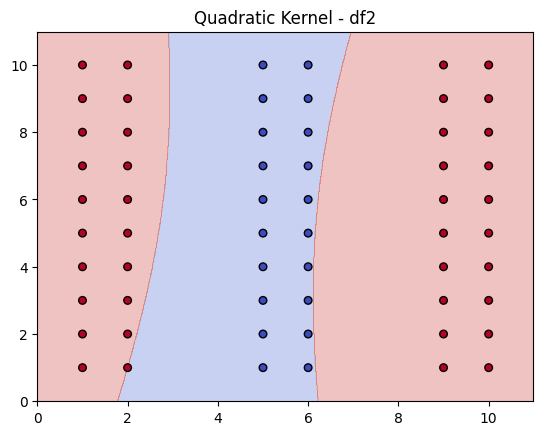

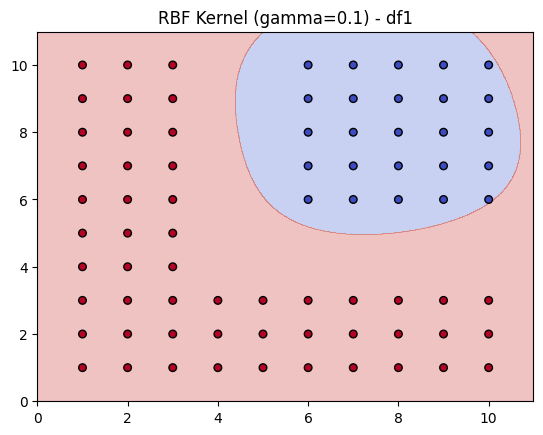

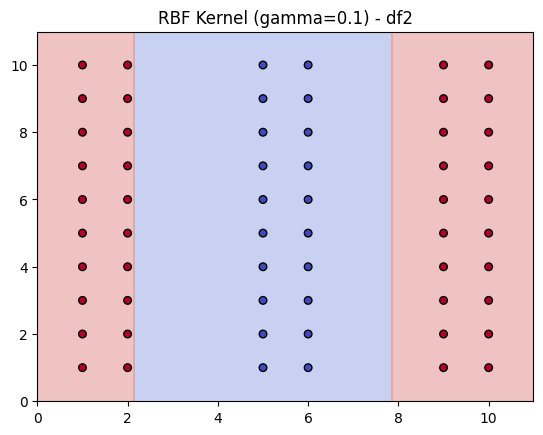

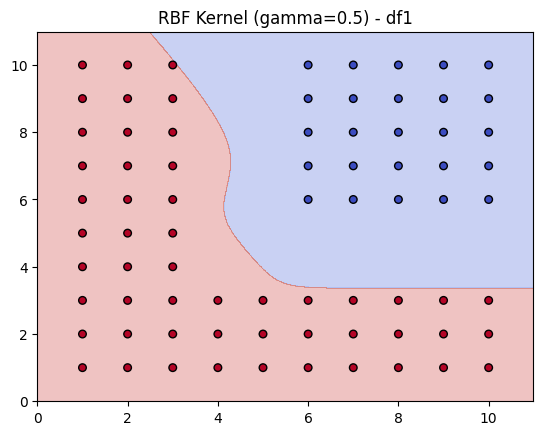

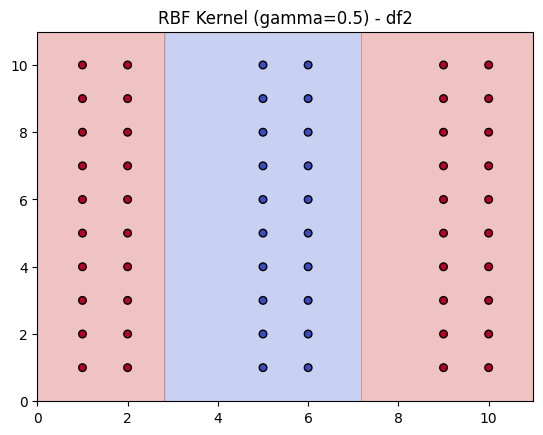

In [14]:
X1, y1 = df1[:, :2], df1[:, 2]
X2, y2 = df2[:, :2], df2[:, 2]

model_quadratic = KernelPerceptron(kernel=quadratic_kernel)
model_quadratic.fit(X1, y1)
plot_decision_boundary(X1, y1, model_quadratic, title="Quadratic Kernel - df1")


model_quadratic_data2 = KernelPerceptron(kernel=quadratic_kernel)
model_quadratic_data2.fit(X2, y2)
plot_decision_boundary(X2, y2, model_quadratic_data2, title="Quadratic Kernel - df2")

gamma_1 = 0.1
model_rbf_data1 = KernelPerceptron(kernel=lambda x1, x2: rbf_kernel(x1, x2, gamma_1))
model_rbf_data1.fit(X1, y1)
plot_decision_boundary(X1, y1, model_rbf_data1, title=f"RBF Kernel (gamma={gamma_1}) - df1")

model_rbf_data2 = KernelPerceptron(kernel=lambda x1, x2: rbf_kernel(x1, x2, gamma_1))
model_rbf_data2.fit(X2, y2)
plot_decision_boundary(X2, y2, model_rbf_data2, title=f"RBF Kernel (gamma={gamma_1}) - df2")

gamma_2 = 0.5
model_rbf_data1_2 = KernelPerceptron(kernel=lambda x1, x2: rbf_kernel(x1, x2, gamma_2))
model_rbf_data1_2.fit(X1, y1)
plot_decision_boundary(X1, y1, model_rbf_data1_2, title=f"RBF Kernel (gamma={gamma_2}) - df1")

model_rbf_data2_2 = KernelPerceptron(kernel=lambda x1, x2: rbf_kernel(x1, x2, gamma_2))
model_rbf_data2_2.fit(X2, y2)
plot_decision_boundary(X2, y2, model_rbf_data2_2, title=f"RBF Kernel (gamma={gamma_2}) - df2")

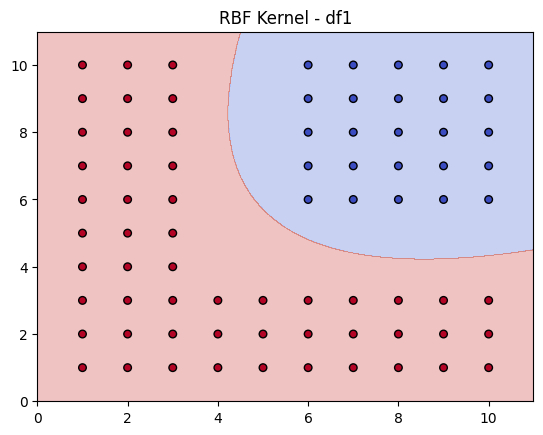

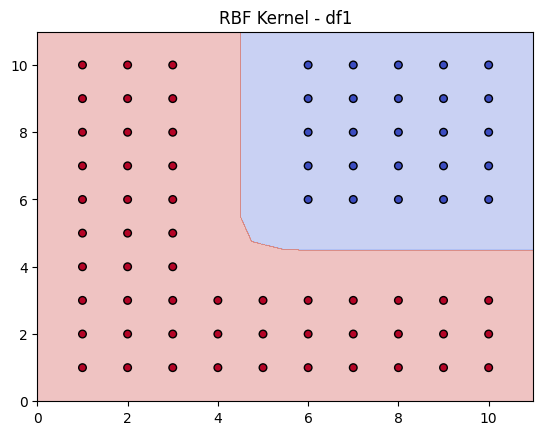

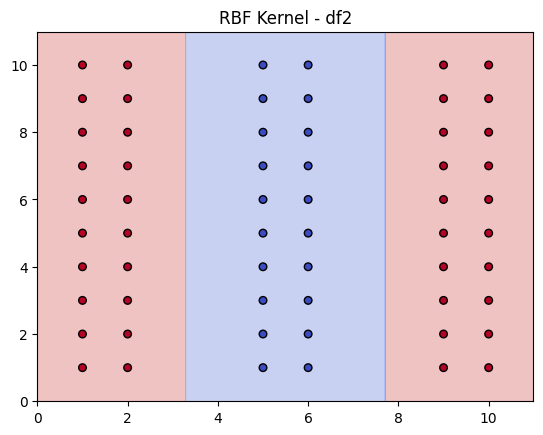

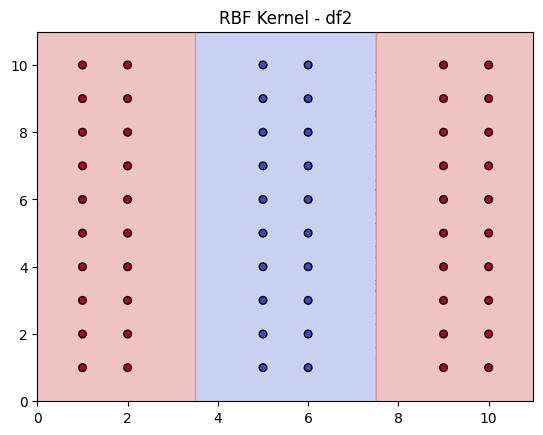

In [11]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X1, y1)
plot_decision_boundary(X1, y1, gpc, title='RBF Kernel - df1, gamma = 1')

kernel = 1.0 * RBF(0.1)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X1, y1)
plot_decision_boundary(X1, y1, gpc, title='RBF Kernel - df1, gamma = 0.1')

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X2, y2)
plot_decision_boundary(X2, y2, gpc, title='RBF Kernel - df2, gamma = 1')

kernel = 1.0 * RBF(0.1)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X2, y2)
plot_decision_boundary(X2, y2, gpc, title='RBF Kernel - df2, gamma = 0.1')

In [9]:
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)
    
# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [10]:
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')

X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (60000, 784)
Test data shape: (10000, 784)
Training labels shape: (60000,)
Test labels shape: (10000,)


In [11]:
X_train = X_train.astype('float32') / 255.0  # Normalize
X_test = X_test.astype('float32') / 255.0  # Normalize

X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
linear_svm_results = {}

for C in C_values:
    print(f"Training Linear SVM with C={C}...")
    model = LinearSVC(C=C, loss='hinge', max_iter=10000)
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    linear_svm_results[C] = {'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("---------------------------")

print("Training Kernel SVM with quadratic kernel (degree=2)...")
kernel_svm_model = SVC(kernel='poly', degree=2, C=1.0)
kernel_svm_model.fit(X_train, y_train)

train_pred_kernel = kernel_svm_model.predict(X_train)
test_pred_kernel = kernel_svm_model.predict(X_test)

train_accuracy_kernel = accuracy_score(y_train, train_pred_kernel)
test_accuracy_kernel = accuracy_score(y_test, test_pred_kernel)

n_support_vectors = len(kernel_svm_model.support_vectors_)

print(f"Kernel SVM (quadratic kernel) Training Accuracy: {train_accuracy_kernel}")
print(f"Kernel SVM (quadratic kernel) Test Accuracy: {test_accuracy_kernel}")
print(f"Number of Support Vectors: {n_support_vectors}")

Training Linear SVM with C=0.01...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy: 0.92115
Test Accuracy: 0.9157
---------------------------
Training Linear SVM with C=0.1...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy: 0.92915
Test Accuracy: 0.9195
---------------------------
Training Linear SVM with C=1.0...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy: 0.9309
Test Accuracy: 0.9182
---------------------------
Training Linear SVM with C=10.0...


# Problem 7b.
## The dataset does not seem to be linearly separable because for larger values of C, the test error increases, thus indicating that the model is overfitting and the data is not well-separated.

### The training was taking too long for the higher values of C, but I would use more max iterations if possible to increase the accuracies.

In [ ]:
linear_svm_results = {}
C = 10.0
print(f"Training Linear SVM with C={10.0}...")
model = LinearSVC(C=C, loss='hinge', max_iter=10000)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

linear_svm_results[C] = {'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("---------------------------")

C = 100.0
print(f"Training Linear SVM with C={100.0}...")
model = LinearSVC(C=C, loss='hinge', max_iter=10000)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

linear_svm_results[C] = {'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("---------------------------")

In [ ]:
%%timeit
print("Training Kernel SVM with quadratic kernel (degree=2)...")
kernel_svm_model = SVC(kernel='poly', degree=2, C=1.0, max_iter=10000)
kernel_svm_model.fit(X_train, y_train)

train_pred_kernel = kernel_svm_model.predict(X_train)
test_pred_kernel = kernel_svm_model.predict(X_test)

train_accuracy_kernel = accuracy_score(y_train, train_pred_kernel)
test_accuracy_kernel = accuracy_score(y_test, test_pred_kernel)

n_support_vectors = len(kernel_svm_model.support_vectors_)

print(f"Kernel SVM (quadratic kernel) Training Accuracy: {train_accuracy_kernel}")
print(f"Kernel SVM (quadratic kernel) Test Accuracy: {test_accuracy_kernel}")
print(f"Number of Support Vectors: {n_support_vectors}")